#### Description:
A home electronics company which manufactures state of the art smart televisions, wants to develop a feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

#### Dataset:
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

#### Objective:
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

#### 1. Importing the Necessary Libraries

In [1]:
#Importing necessary libraries

import os
import cv2
import math
import scipy
import datetime
import numpy as np
import matplotlib.pyplot as plt

#### 2. We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

#### 3. Reading the Data

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip '/content/drive/MyDrive/Data_sets/Project_data.zip'

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size
train_dir_size = len(train_doc)
print(len(train_doc))

663


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

#### 4. Creating Image Generator Object

In [5]:
frames, height, width, channels = 30, 80, 80, 3 #x,y,z,c

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,1)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = math.floor(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #print(image.shape)
                    if image.shape[0]!=image.shape[1]:
                        peripheral_crop = int((image.shape[1]-image.shape[0])/2)
                        image_cropped = image[:,peripheral_crop:-peripheral_crop]
                        resized_image = cv2.resize(image_cropped, (80,80))
                    else:
                        resized_image = cv2.resize(image, (80,80))
                    
                    batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255.0
                    batch_data[folder,idx,:,:,1] = resized_image[:,:,1]/255.0
                    batch_data[folder,idx,:,:,2] = resized_image[:,:,2]/255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_size = int(((len(folder_list)/batch_size)-math.floor(len(folder_list)/batch_size))*batch_size)
        batch_data = np.zeros((remaining_size,frames,height,width,3))
        batch_labels = np.zeros((remaining_size,5))
        for folder in range(remaining_size): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if image.shape[0]!=image.shape[1]:
                        peripheral_crop = int((image.shape[1]-image.shape[0])/2)
                image_cropped = image[:,peripheral_crop:-peripheral_crop]
                resized_image = cv2.resize(image_cropped, (80,80))

                batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255.0
                batch_data[folder,idx,:,:,1] = resized_image[:,:,1]/255.0
                batch_data[folder,idx,:,:,2] = resized_image[:,:,2]/255.0

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

#### 5. Predefining Constants

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 3 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 3


## Model 1 - (Basic Conv3D - 7Layers - Batch_size=512) 

#### 6. Building Model Architecture

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = tf.keras.Sequential()

model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(frames,height,width,channels)))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 78, 78, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 39, 39, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 124416)            0         
                                                                 
 dense (Dense)               (None, 256)               3

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

#### 7. Defining Model Parameters

In [9]:
batch_size=512

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

#### 8. Training the Model

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 512
Epoch 1/3


## Model 2 - (Basic Conv3D - 7Layers - Batch_size=256) 

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = tf.keras.Sequential()

model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(frames,height,width,channels)))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 78, 78, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 39, 39, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 124416)            0         
                                                                 
 dense (Dense)               (None, 256)               3

In [9]:
batch_size=256

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [10]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 256
Epoch 1/3


ResourceExhaustedError: ignored

## Model 3 - (Basic Conv3D - 7Layers - Batch_size=128) 

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = tf.keras.Sequential()

model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(frames,height,width,channels)))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 28, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 14, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 124416)            0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [12]:
batch_size=128

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 128
Epoch 1/3


ResourceExhaustedError: ignored

## Model 4 - (Basic Conv3D - 7Layers - Batch_size=64) 

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = tf.keras.Sequential()

model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(frames,height,width,channels)))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 28, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 14, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 12, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 6, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 124416)            0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [15]:
batch_size=64

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - ETA: 0s - loss: 3.6024 - categorical_accuracy: 0.2428Source path =  Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.38545, saving model to model_init_2022-12-1412_17_17.158061/model-00001-3.60244-0.24284-1.38545-0.49000.h5
11/11 [==============================] - 63s 6s/step - loss: 3.6024 - categorical_accuracy: 0.2428 - val_loss: 1.3854 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - ETA: 0s - loss: 1.3149 - categorical_accuracy: 0.4796
Epoch 2: val_loss improved from 1.38545 to 1.16545, saving model to model_init_2022-12-1412_17_17.158061/model-00002-1.31486-0.47964-1.16545-0.42000.h5
11/11 [==============================] - 59s 6s/step - loss: 1.3149 - categorical_accuracy: 0.4796 - val_loss: 1.1655 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 3/3
10/11 [==========================>...] - ETA: 

## Model 5 - (Basic Conv3D, 7Layers, Batch_size=64, Increasing epochs from 3 to 20) 

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

model = tf.keras.Sequential()

model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(frames,height,width,channels)))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 28, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 14, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 12, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 6, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 124416)            0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [18]:
batch_size=64
num_epochs=20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 4.4865 - categorical_accuracy: 0.2097Source path =  Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.60676, saving model to model_init_2022-12-1412_17_17.158061/model-00001-4.48651-0.20965-1.60676-0.24000.h5
11/11 [==============================] - 61s 6s/step - loss: 4.4865 - categorical_accuracy: 0.2097 - val_loss: 1.6068 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5333 - categorical_accuracy: 0.2549
Epoch 2: val_loss improved from 1.60676 to 1.38133, saving model to model_init_2022-12-1412_17_17.158061/model-00002-1.53332-0.25490-1.38133-0.30000.h5
11/11 [==============================] - 60s 6s/step - loss: 1.5333 - categorical_accuracy: 0.2549 - val_loss: 1.3813 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ET

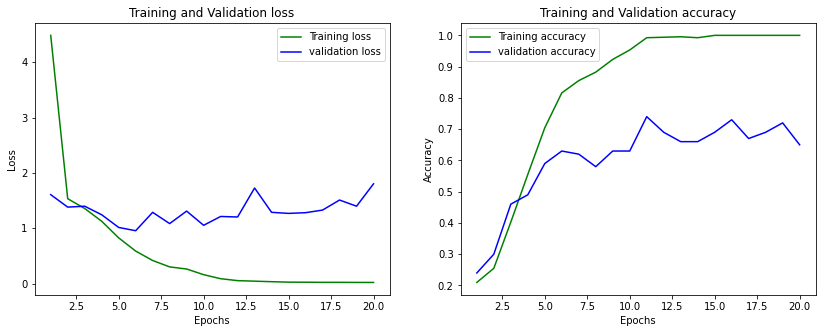

In [20]:
#Plotting the Training History

loss_train = model.history.history['loss']
loss_val = model.history.history['val_loss']
acc_train = model.history.history['categorical_accuracy']
acc_val = model.history.history['val_categorical_accuracy']

epochs = range(1,len(loss_train)+1)

plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model 6 - (CNN + RNN, 9 Layers, Batch_size=64, 20 Epochs)

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

model_cnn2D = tf.keras.Sequential()

model_cnn2D.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(height,width,channels)))
model_cnn2D.add(MaxPooling2D(pool_size=(2,2)))
model_cnn2D.add(Dropout(0.2))

model_cnn2D.add(BatchNormalization())
model_cnn2D.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn2D.add(MaxPooling2D(pool_size=(2,2)))
model_cnn2D.add(Dropout(0.2))

model_cnn2D.add(Flatten())

model = tf.keras.Sequential()

model.add(TimeDistributed(model_cnn2D,input_shape=(30,height,width,channels)))
model.add(GRU(128,input_shape=(None,30,128),return_sequences=True))
model.add(GRU(32))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 20736)        19520     
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 30, 128)           8012544   
                                                                 
 gru_1 (GRU)                 (None, 32)                15552     
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
Total params: 8,047,781
Trainable params: 8,047,717
Non-trainable params: 64
_________________________________________________________________
None


In [22]:
num_epochs=10
batch_size=64

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 1.9895 - categorical_accuracy: 0.2247Source path =  Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.87630, saving model to model_init_2022-12-1412_17_17.158061/model-00001-1.98952-0.22474-1.87630-0.22000.h5
11/11 [==============================] - 71s 6s/step - loss: 1.9895 - categorical_accuracy: 0.2247 - val_loss: 1.8763 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.6334 - categorical_accuracy: 0.2730
Epoch 2: val_loss improved from 1.87630 to 1.59944, saving model to model_init_2022-12-1412_17_17.158061/model-00002-1.63345-0.27300-1.59944-0.16000.h5
11/11 [==============================] - 72s 7s/step - loss: 1.6334 - categorical_accuracy: 0.2730 - val_loss: 1.5994 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ET

## Model 7 - (CNN + RNN, 13 Layers, Batch_size=64, 50 Epochs)

In [25]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

model_cnn2D = tf.keras.Sequential()

model_cnn2D.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(height,width,channels)))
model_cnn2D.add(MaxPooling2D(pool_size=(2,2)))
model_cnn2D.add(Dropout(0.2))

#model_cnn2D.add(BatchNormalization())
model_cnn2D.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn2D.add(MaxPooling2D(pool_size=(2,2)))
model_cnn2D.add(Dropout(0.2))

#model_cnn2D.add(BatchNormalization())
model_cnn2D.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
model_cnn2D.add(MaxPooling2D(pool_size=(2,2)))
#model_cnn2D.add(Dropout(0.2))

model_cnn2D.add(Flatten())

model = tf.keras.Sequential()

model.add(TimeDistributed(model_cnn2D,input_shape=(30,height,width,channels)))
model.add(GRU(128,input_shape=(None,30,128),return_sequences=True))
model.add(GRU(32))
model.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 30, 4096)         56320     
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 30, 128)           1622784   
                                                                 
 gru_3 (GRU)                 (None, 32)                15552     
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,694,821
Trainable params: 1,694,821
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
num_epochs=50
batch_size=64

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 13.6383 - categorical_accuracy: 0.2700Source path =  Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 11.62192, saving model to model_init_2022-12-1412_17_17.158061/model-00001-13.63835-0.26998-11.62192-0.18000.h5
11/11 [==============================] - 76s 7s/step - loss: 13.6383 - categorical_accuracy: 0.2700 - val_loss: 11.6219 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 10.2750 - categorical_accuracy: 0.3167
Epoch 2: val_loss improved from 11.62192 to 8.68752, saving model to model_init_2022-12-1412_17_17.158061/model-00002-10.27505-0.31674-8.68752-0.33000.h5
11/11 [==============================] - 72s 7s/step - loss: 10.2750 - categorical_accuracy: 0.3167 - val_loss: 8.6875 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/50
11/11 [==========================

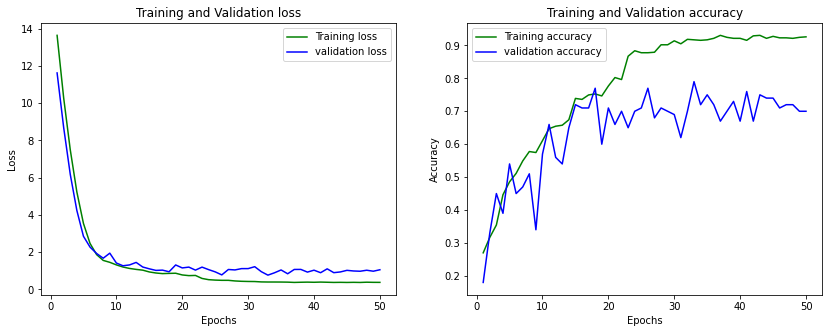

In [28]:
#Plotting the Training History

loss_train = model.history.history['loss']
loss_val = model.history.history['val_loss']
acc_train = model.history.history['categorical_accuracy']
acc_val = model.history.history['val_categorical_accuracy']

epochs = range(1,len(loss_train)+1)

plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()